# 様々な方法でAccやLossを保存してみる

コードはPytorchの公式[チュートリアル](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)を使用した　


In [1]:
%matplotlib inline

In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

### 使用する画像をダウンロードする
   Download the data from
   [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip)
   and extract it to the current directory.

dataという名前のディレクトリを作成してその中にダウンロードしたzipを展開する　　

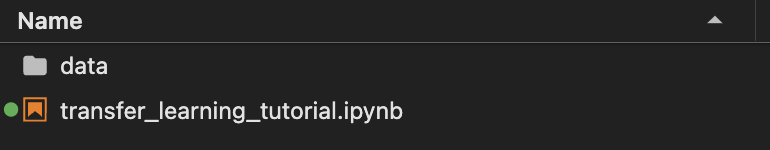

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")

## Visualize a few images
Let's visualize a few training images so as to understand the data
augmentations.



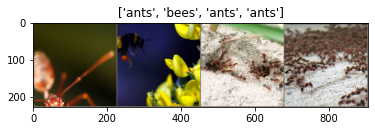

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Finetuning the convnet

Load a pretrained model and reset final fully connected layer.




In [5]:
def model_criterion_optim_shche():
    model_ft = models.resnet18(pretrained=True)
    num_ftrs = model_ft.fc.in_features
    # Here the size of each output sample is set to 2.
    # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
    model_ft.fc = nn.Linear(num_ftrs, 2)

    model = model_ft.to(device)

    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    return model, criterion, optimizer, scheduler

In [6]:
model, criterion, optimizer, scheduler = model_criterion_optim_shche()

## Train and evaluate

### print文で出力する

そのまま実行するとprint文でaccとlossが出力されるだけ

In [7]:
num_epochs = 10 # デフォルトでは25だけどとりあえず10にした

since = time.time()

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        if phase == 'train':
            scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # deep copy the model
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    print()

Epoch 0/9
----------
train Loss: 0.7653 Acc: 0.5861
val Loss: 0.4405 Acc: 0.7908

Epoch 1/9
----------
train Loss: 0.3064 Acc: 0.8648
val Loss: 0.3962 Acc: 0.8627

Epoch 2/9
----------
train Loss: 0.4849 Acc: 0.8320
val Loss: 0.2512 Acc: 0.9020

Epoch 3/9
----------
train Loss: 0.6626 Acc: 0.7623
val Loss: 0.4900 Acc: 0.8693

Epoch 4/9
----------
train Loss: 0.6190 Acc: 0.7992
val Loss: 0.4117 Acc: 0.8366

Epoch 5/9
----------
train Loss: 0.4942 Acc: 0.8033
val Loss: 0.3334 Acc: 0.8562

Epoch 6/9
----------
train Loss: 0.4725 Acc: 0.7787
val Loss: 0.2991 Acc: 0.8824

Epoch 7/9
----------
train Loss: 0.2327 Acc: 0.9098
val Loss: 0.2499 Acc: 0.9085

Epoch 8/9
----------
train Loss: 0.2899 Acc: 0.8443
val Loss: 0.2367 Acc: 0.9216

Epoch 9/9
----------
train Loss: 0.3307 Acc: 0.8730
val Loss: 0.2565 Acc: 0.9020



### pandas.DataFrameを使い, AccとLossを保存する

In [8]:
import pandas as pd

In [9]:
# とりあえず使ってみる
# columnsだけ指定してDataFrameを作成
df = pd.DataFrame(columns=["Train Loss", "Train Acc", "Val Loss", "Val Acc",])
df

,Train Loss,Train Acc,Val Loss,Val Acc


In [10]:
# こんな感じに出力結果を入れていく
df.loc[0, "Train Acc"] = 0.5
df

,Train Loss,Train Acc,Val Loss,Val Acc
0,NaN,0.5,NaN,NaN


#### 組み込んでみる

In [11]:
model, criterion, optimizer, scheduler = model_criterion_optim_shche()

In [12]:
num_epochs = 10 # デフォルトでは25だけどとりあえず10にした

since = time.time()

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

# DataFrame作成
result_df = pd.DataFrame(columns=["Train Loss", "Train Acc", "Val Loss", "Val Acc"])

for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        if phase == 'train':
            scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        
        
        # print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        if phase == "train":
            result_df.loc[epoch, "Train Loss"] = epoch_loss
            result_df.loc[epoch, "Train Acc"] = epoch_acc.cpu().numpy()
        elif phase == "val":
            result_df.loc[epoch, "Val Loss"] = epoch_loss
            result_df.loc[epoch, "Val Acc"] = epoch_acc.cpu().numpy()

        # deep copy the model
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    print()
result_df.to_csv("./result_df.csv", index=False)

Epoch 0/9
----------

Epoch 1/9
----------

Epoch 2/9
----------

Epoch 3/9
----------

Epoch 4/9
----------

Epoch 5/9
----------

Epoch 6/9
----------

Epoch 7/9
----------

Epoch 8/9
----------

Epoch 9/9
----------



In [13]:
# read_csvしてresult_dfの中身を見てみる
df = pd.read_csv("./result_df.csv")
df

,Train Loss,Train Acc,Val Loss,Val Acc
0,0.577519,0.750000,0.288145,0.895425
1,0.539507,0.795082,0.353020,0.856209
2,0.466391,0.827869,0.264601,0.915033
3,0.484521,0.807377,0.354298,0.849673
4,0.551792,0.770492,0.280707,0.895425
5,0.387019,0.823770,0.284869,0.856209
6,0.339732,0.864754,0.312237,0.888889
7,0.396320,0.852459,0.318359,0.882353
8,0.346573,0.836066,0.212465,0.921569
9,0.374271,0.836066,0.217019,0.921569
